Imports.

In [1]:
from enum import Enum
from typing import NamedTuple
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, ZeroPadding2D, Input,\
                         UpSampling2D, Cropping2D, Conv2DTranspose
from keras.layers.merge import concatenate
import keras
from numba import njit

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Definitions, initializations and utils.

In [2]:
#The tolerance for floating pointer comparison.
epsilon = 0.000001

#The complexity of the variogram models.
numberOfNestedStructures = 4
numberOfParametersPerNestedStructure = 4 #ATTENTION: if you change this value, you must change the makeVariogramModelSurface() function accordingly
totalNumberOfParameters = numberOfNestedStructures * numberOfParametersPerNestedStructure

#The target sill for the variogram models.
sill = 0.64

#The range for the longest structure allowed in the variogram models.
maxAxis = 50.0

class StructureType(Enum):
    Spheric     = 1
    Exponential = 2
    Gaussian    = 3
    
class EllipsoidParameters(NamedTuple):
    Azimuth      : float
    SemiMajorAxis: float
    SemiMinorAxis: float

class GridParameters(NamedTuple):
    X0: float
    Y0: float
    DX: float
    DY: float
    NI: int
    NJ: int

def getExtent2D( gridParameters : GridParameters ) -> np.array :
    gridCornerX = gridParameters.X0 - gridParameters.DX/2;
    gridCornerY = gridParameters.Y0 - gridParameters.DY/2;
    return [
           gridCornerX,
           gridCornerX + gridParameters.DX*gridParameters.NI,
           gridCornerY,
           gridCornerY + gridParameters.DY*gridParameters.NJ
           ]

def getVarmapGridParameters() -> GridParameters :
    return GridParameters( X0=-50., Y0=-50., 
                           DX=1,    DY=1, 
                           NI=100,  NJ=100 )

def getInputGridParameters() -> GridParameters :
    return GridParameters( X0=0., Y0=0., 
                           DX=1,    DY=1, 
                           NI=100,  NJ=100 )

def cartesianToPolar( X : np.array, Y : np.array ) -> ( np.array, np.array ) :
    rho = np.sqrt( X**2 + Y**2 )
    phi = np.arctan2( Y, X )
    return( rho, phi )

def polarToCartesian( magnitude : np.array, phase : np.array ) -> ( np.array, np.array ) :
    X = magnitude * np.cos( phase )
    Y = magnitude * np.sin( phase )
    return(X, Y)

Function to generate a variographic surface for one nested structure.

In [3]:
@njit
def makeVariographicSurface( structureType       : StructureType, 
                             ellipsoidParameters : EllipsoidParameters, 
                             contribution        : float,
                             gridParameters      : GridParameters ) -> np.array :
   #NOTA VARIAVEIS COM [0] APARENTEMENTE DE FORMA DESNECESSARIA
   #sem isso dá erro de tipo não reconhecido (array) ao tentar usar com o JIT do Numba.
   #
   #Cria o numpy.array seguindo os parâmetros do grid.
   grid = np.zeros(( gridParameters.NI, gridParameters.NJ ));
   #Check for null structure
   if( contribution[0] < epsilon or 
       ellipsoidParameters.SemiMajorAxis[0] < epsilon or 
       ellipsoidParameters.SemiMinorAxis[0] < epsilon ) :
       return grid;
   #Obtem parâmetros geométricos
   a = ellipsoidParameters.SemiMajorAxis;
   b = ellipsoidParameters.SemiMinorAxis;
   c = contribution;                                       #contribution to semivariance
   theta = ellipsoidParameters.Azimuth/180.0 * math.pi; #azimuth
   xc = gridParameters.X0 - gridParameters.DX/2 + gridParameters.DX*gridParameters.NI/2; #center of the grid
   yc = gridParameters.Y0 - gridParameters.DY/2 + gridParameters.DY*gridParameters.NJ/2; #center of the grid
   cos_theta = math.cos(theta[0])
   sin_theta = math.sin(theta[0])
   #Calcula o variograma em cada célula do grid   
   for j in range( gridParameters.NJ ) :
      yCell = gridParameters.Y0 + gridParameters.DY * j;
      for i in range( gridParameters.NI ) :
         xCell = gridParameters.X0 + gridParameters.DX * i;
         x = (xCell - xc) * cos_theta - (yCell - yc) * sin_theta;
         y = (xCell - xc) * sin_theta + (yCell - yc) * cos_theta;
         modulusSquared = (x/a)*(x/a) + (y/b)*(y/b);
         h = math.sqrt( modulusSquared[0] );
         if( h >= 0. and h <= 1. ) :
            semivariance = c * (3*h/2.-math.pow(h, 3)/2.);
         else :
            semivariance = c;
         grid[i,j] = semivariance[0];
   #retorna o grid
   return grid;

Function to generate the surface for a variogram model.

In [4]:
# The parameters must be a linear 16-element array of floats in the following order:
# azimuth, semi-major axis, semi-minor axis, contribution, azimuth, ...
# for four structures.  Models with less than for structures can be specified with all-zero parameters
def makeVariogramModelSurface( parameters : np.array ) -> np.array :
    gridParameters = getVarmapGridParameters()
    variogramModelSurface = np.zeros(( gridParameters.NI, gridParameters.NJ ));
    for i in range( numberOfNestedStructures ) :
        variogramModelSurface += \
            makeVariographicSurface( structureType = StructureType.Spheric, 
                                     ellipsoidParameters = EllipsoidParameters( Azimuth      =parameters[i*numberOfParametersPerNestedStructure+0], 
                                                                                SemiMajorAxis=parameters[i*numberOfParametersPerNestedStructure+1], 
                                                                                SemiMinorAxis=parameters[i*numberOfParametersPerNestedStructure+2] ), 
                                     contribution=parameters[i*numberOfParametersPerNestedStructure+3],
                                     gridParameters = gridParameters )
    return variogramModelSurface;


Function to synthetize a map from variographic parameters with the Fourier Integral Method.

In [5]:
# The parameters must be a linear 16-element array of floats in the following order:
# azimuth, semi-major axis, semi-minor axis, contribution, azimuth, ...
# for four structures.  Models with less than for structures can be specified with all-zero parameters
# scaleMin, scaleMax: the output is rescaled to these values.
def synthetizeFIM( parameters : np.array,
                   scaleMin : float,
                   scaleMax : float ) -> np.array  :
    #Make the random variogram surface.
    variogramModelSurface = makeVariogramModelSurface( parameters );
    
    #Make it a correlographic surface.
    correlogramModelSurface = sill - variogramModelSurface
    
    #Compute FFT of the correlogram surface.
    correlogramModelFFT = np.fft.fft2( correlogramModelSurface ) 

    #The amplitude spectrum of the correlogram is the spectral density,
    #so we take the square root of it.  Then we can use it with the phase map
    #of the input to reverse-FFT to get a synthetic map.
    syntheticAmplitude = np.sqrt( np.absolute( correlogramModelFFT ) )

    #Convert the synthetic fft from polar form to Cartesian form
    syntheticRealPart, syntheticImaginaryPart = polarToCartesian( syntheticAmplitude, inputPhaseDecentered )

    #Make an array with complex values
    syntheticFFT = syntheticRealPart + 1j * syntheticImaginaryPart
    
    #Apply the principle of the Fourier Integral Method to synthetize a map with
    #different morphology.
    syntheticMap = np.real( np.fft.ifft2( syntheticFFT ) ) #the imaginart part should be zero
    
    #Re-scale the synthetic result to match the input's scale
    syntheticMap = scaleMin + \
           ( syntheticMap - syntheticMap.min() ) / ( syntheticMap.max() - syntheticMap.min() ) * \
           ( scaleMax - scaleMin )
    
    return syntheticMap

Load input data.

min = 0.0; max  = 2.9855177


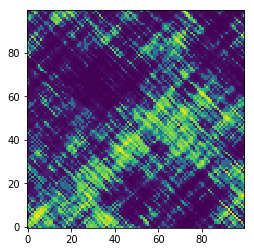

In [6]:
#Load the input map from the GEO-EAS format (has some headers to skip).
inputMap = np.loadtxt(fname = "../GR_TESE_ML/uncond_SGSIM.grid", skiprows=3)

#reshape the data column to 2D image.
inputMap = inputMap.reshape(( getInputGridParameters().NI, getInputGridParameters().NJ ))

#swap the array vertically to conform to GEO-EAS sweep order.
inputMap = inputMap[::-1]

#plot the input varmap.
plt.imshow( inputMap, interpolation='none', extent=getExtent2D( getInputGridParameters() ))

print( "min = " + str(inputMap.min()) + "; max  = " + str(inputMap.max()) )

Compute FFT of input.

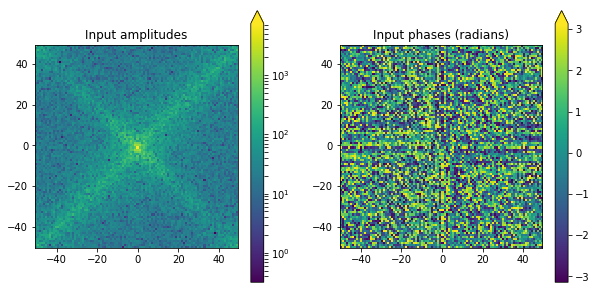

In [7]:
#Compute FFT of the input map.
inputFFT = np.fft.fft2( inputMap )

#Centers the lower frequencies components.
inputFFT = np.fft.fftshift( inputFFT )

#Obtain the amplitude spectrum.
inputAmplitude = np.absolute( inputFFT )

#Obtain the phase spectrum.
inputPhase = np.angle( inputFFT )

#=====================Plot both spectra.==========================
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
mappable = ax[0].imshow( inputAmplitude, norm=colors.LogNorm(vmin=inputAmplitude.min(), vmax=inputAmplitude.max()),
                    interpolation='none',
                    extent=getExtent2D( getVarmapGridParameters() ))
ax[0].set_title( "Input amplitudes")
#pcm = ax[0].pcolor(inputAmplitude,
#                   norm=colors.LogNorm(vmin=inputAmplitude.min(), vmax=inputAmplitude.max()),
#                   cmap='PuBu_r')
fig.colorbar(mappable, ax=ax[0], extend='max')

#pcm = ax[1].pcolor(inputPhase, cmap='PuBu_r')
#fig.colorbar(pcm, ax=ax[1], extend='max')
mappable = ax[1].imshow( inputPhase,
                    interpolation='none',
                    extent=getExtent2D( getVarmapGridParameters() ))
ax[1].set_title( "Input phases (radians)")
fig.colorbar(mappable, ax=ax[1], extend='max')
plt.show()
#==================================================================

Sinthetize data for training.  These maps are generates with the Fourier Integral Method with synthetic geometries, but positioned in the same places of the input data because the maps are synthetized with the input's phase map.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide


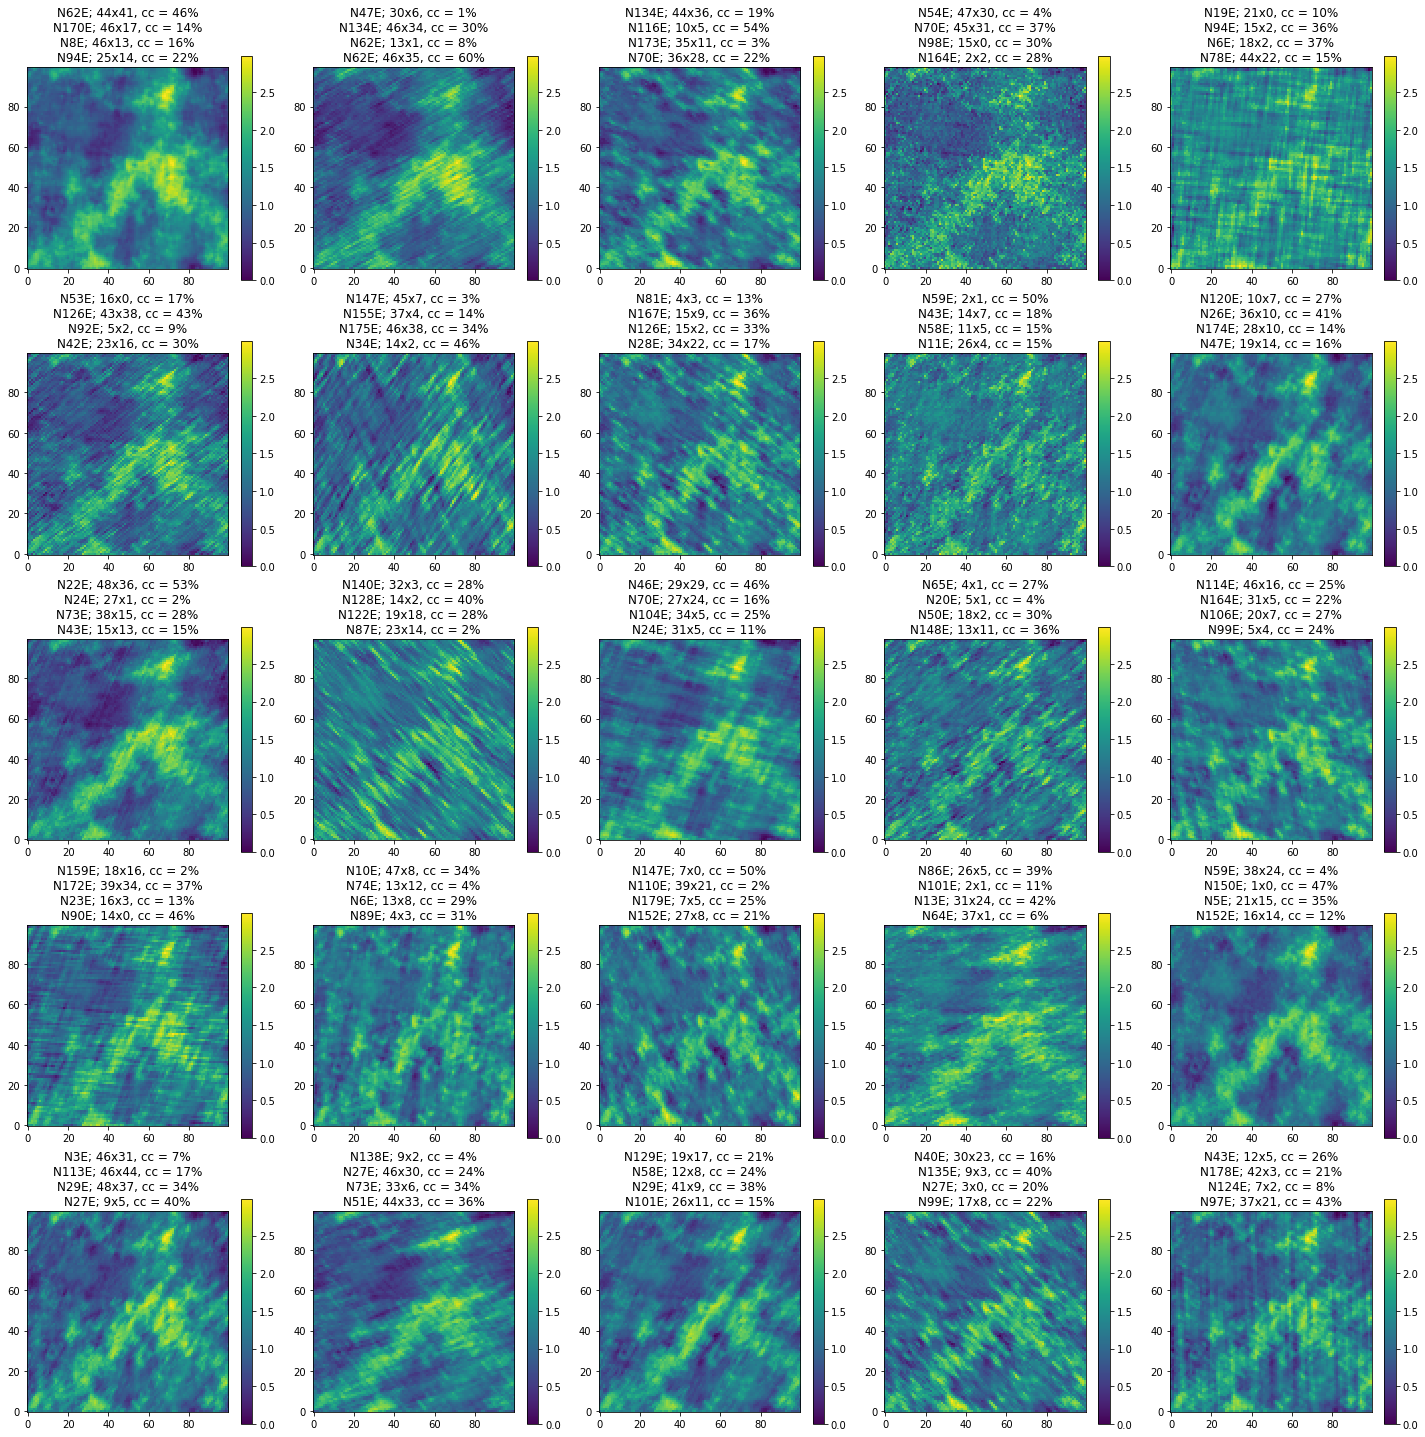

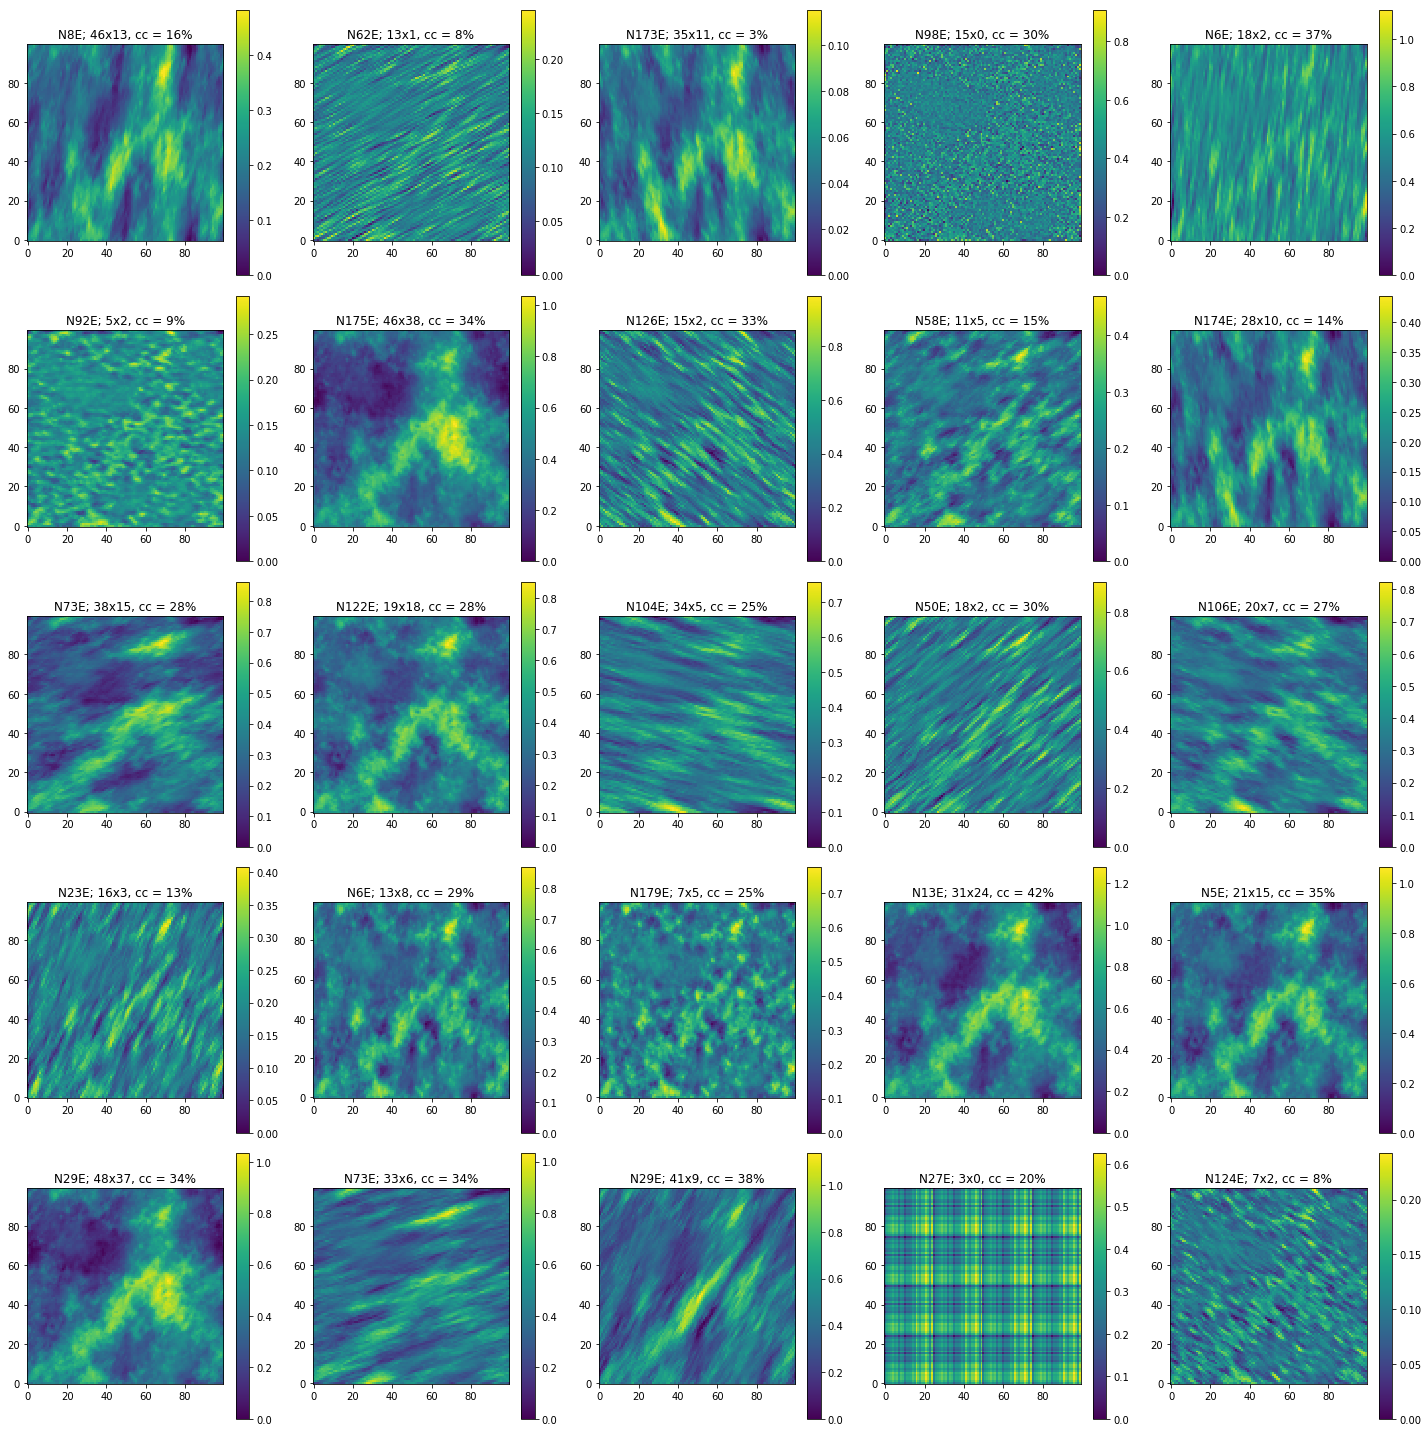

In [14]:
#The number of random synthetic maps to generate.
n = 5500

#Allocate a volume for the stack of all synthetic maps: n * 100 * 100 * 4 (repeated four times as z-slices).
allSyntheticMaps = np.zeros(( n, getInputGridParameters().NI, getInputGridParameters().NJ, numberOfNestedStructures))

#Allocate a volume for the stack of all synthetic structures: n * 100 * 100 * 4 (each structure as z-slices).
allSyntheticStructures = np.zeros(( n, getInputGridParameters().NI, getInputGridParameters().NJ, numberOfNestedStructures))

#Allocate the stack of variographic parameters: n * 16 * 1.
allParameters = np.zeros(( n, totalNumberOfParameters, 1))

#Get the de-centered version of the input's phase map for compatibility with np.ifft2().
inputPhaseDecentered = np.fft.fftshift( inputPhase )

#Generate the synthetic maps for training with the Fourier Integral Method.
for iVariogram in range(n):
    
    #Radomize the azimuths (N000E through N180E).
    az = np.random.rand(numberOfNestedStructures, 1)
    
    #Randomize the semi-major axes.
    a = np.random.rand(numberOfNestedStructures, 1)

    #Randomize the semi-minor axes such that they are necessarily smaller than the semi-major axes.
    b = np.multiply( a, np.random.rand(numberOfNestedStructures, 1) )
    
    #Randomize the contributions such that they sum up to a total (variogram sill).
    cc = np.random.rand(numberOfNestedStructures, 1) 
    cc = cc / np.sum(cc)
    
    #Linearize the array of unitized variographic parameters.
    linearArrayOfParametersUnitized = np.column_stack( (az, a, b, cc) ).reshape(totalNumberOfParameters,1)

    #Linearize the array of full scale variographic parameters.
    linearArrayOfParametersFullScale = np.column_stack( (az*180, a*maxAxis, b*maxAxis, cc*sill) ).reshape(totalNumberOfParameters,1)
    
    #Make the random variogram surface.
    syntheticMap = synthetizeFIM( linearArrayOfParametersFullScale, inputMap.min(), inputMap.max() );
    
    #Stack the synthetic map
    for i in range(numberOfNestedStructures) :
        allSyntheticMaps[iVariogram,:,:,i] = syntheticMap

    #Stack the synthetic structures
    for i in range(numberOfNestedStructures) :
        structPars = np.zeros( ( totalNumberOfParameters, 1 ) )
        #the other structures remain zeroed so the effect is only one synthetic structure synthetized
        for j in range( numberOfParametersPerNestedStructure ) :
            structPars[ i*numberOfNestedStructures+j ] = linearArrayOfParametersFullScale[ i*numberOfNestedStructures+j ]
        allSyntheticStructures[iVariogram,:,:,i] = synthetizeFIM( structPars, \
                                                                  inputMap.min(), \
                                                                  (inputMap.max()-inputMap.min()) * cc[i] )
    
    #Stack the linearized variographic parameters
    allParameters   [iVariogram,:,:] = linearArrayOfParametersUnitized

#Prepare a plot area measuring 5 by 5 figures, each measuring 20x20
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))

#Plot the first 25 synthetic maps to check data
iMap = int(0)
for ax in axs.flat:

    #plot the synthetic map
    mappable = ax.imshow( allSyntheticMaps[iMap,:,:,0], #the map is repeated along the z-slices
                    interpolation='none',
                    extent=getExtent2D( getInputGridParameters() ))
    fig.colorbar(mappable, ax=ax)
    ax.set_title( "N" + str(int(allParameters[iMap,0,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,1,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,2,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,3,0])) + "%\n" + 
                  "N" + str(int(allParameters[iMap,4,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,5,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,6,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,7,0])) + "%\n" + 
                  "N" + str(int(allParameters[iMap,8,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,9,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,10,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,11,0])) + "%\n" + 
                  "N" + str(int(allParameters[iMap,12,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,13,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,14,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,15,0])) + "%" )
    
    #Increment the synthetic map index/count
    iMap = iMap + 1
    
#Lay out the plots
plt.tight_layout()
plt.show()

#Plot the first 25 i-nd synthetic structures to check data
#Prepare a plot area measuring 5 by 5 figures, each measuring 20x20
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
iMap = int(0)
iStru = int(2)
for ax in axs.flat:

    #plot the synthetic map
    mappable = ax.imshow( allSyntheticStructures[iMap,:,:,iStru], 
                    interpolation='none',
                    extent=getExtent2D( getInputGridParameters() ))
    fig.colorbar(mappable, ax=ax)
    ax.set_title( "N" + str(int(allParameters[iMap,iStru*numberOfNestedStructures+0,0]*180)) + "E; " 
                      + str(int(allParameters[iMap,iStru*numberOfNestedStructures+1,0]*maxAxis)) + "x"
                      + str(int(allParameters[iMap,iStru*numberOfNestedStructures+2,0]*maxAxis)) + ", cc = "
                      + str(int(100*allParameters[iMap,iStru*numberOfNestedStructures+3,0])) + "%" )
    
    #Increment the synthetic map index/count
    iMap = iMap + 1
    
#Lay out the plots
plt.tight_layout()
plt.show()



Build the training and test sets.  Build the CNN model.

In [15]:
#Normalize input data.
#normalizer   = StandardScaler()
#X_norm = normalizer.fit_transform(X)
#check whether the normalizer actually rescale to 0.0-1.0 or does a normal score.
#normalizar as superfícies teóricas e o experimental na mesma escala (max de todos os mapas + experimental)
#colocar camadas de max/min pooling depois de cada camada convolutiva
#ver rede LeNet dado em um dos notebooks da aula.

#Dividir o conjunto total de superfícies variográficas e seus parâmetros em dois conjuntos:
#  1) O conjunto de treinamento, para o processamento do backpropagation.
#  2) O conjunto de teste, para aferição de métricas de acurácia da predição
trainSyntheticMaps, testSyntheticMaps, trainSyntheticStructures, testSyntheticStructures = \
      train_test_split(allSyntheticMaps, allSyntheticStructures, test_size=0.25, random_state=11111)
    
#Talvez tenha que rescalar os mapas de entrada para 0.0-1.0

#Compatibiliza os dados de entrada para uso no Keras, que espera tensores (matrizes de ordem maior que 2)
#de ordem 4: # de imagens, dimensão I de cada imagem, dimensão J de cada imagem, # de canais em cada imagem
#trainSyntheticMaps = trainSyntheticMaps.reshape(trainSyntheticMaps.shape + (1,)) #(1,) significa uma tupla de um elemento
#testSyntheticMaps  = testSyntheticMaps.reshape(testSyntheticMaps.shape + (1,))

#Unitizando os mapas sintéticos (escala de 0.0 a 1.0 e as estruturas, proporcionalmente dentro dessa escala)
delta = allSyntheticMaps.max() - allSyntheticMaps.min()
trainSyntheticMaps = trainSyntheticMaps / delta;
testSyntheticMaps = testSyntheticMaps / delta;
trainSyntheticStructures = trainSyntheticMaps / delta;
testSyntheticStructures = testSyntheticMaps / delta;

#Cria a parte convolutiva da arquitetura de rede
input_layer = Input(shape=(getInputGridParameters().NI, getInputGridParameters().NJ, numberOfNestedStructures))
zp = ZeroPadding2D(padding=((14,14),(14,14))) ( input_layer )
conv1 = Conv2D(100, kernel_size=3, activation='relu', padding='same') ( zp ) #camada convolutiva de 10 kernels (corresponde a 10 neurônios)
mp1 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv1 )
conv2 = Conv2D(200, kernel_size=3, activation='relu', padding='same') ( mp1 ) #camada convolutiva de 20 kernels (corresponde a 20 neurônios)
mp2 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv2 )
conv3 = Conv2D(400, kernel_size=3, activation='relu', padding='same') ( mp2 ) #camada convolutiva de 40 kernels (corresponde a 40 neurônios)
mp3 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv3 )
conv4 = Conv2D(800, kernel_size=3, activation='relu', padding='same') ( mp3 ) #camada convolutiva de 80 kernels (corresponde a 40 neurônios)
mp4 = MaxPooling2D(pool_size=(2, 2)) ( conv4 )
#conv5 = Conv2D(160, kernel_size=3, activation='relu', padding='same') ( mp4 ) #camada convolutiva de 160 kernels (corresponde a 40 neurônios)
#mp5 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv5 )
#conv6 = Conv2D(320, kernel_size=3, activation='relu', padding='same') ( mp5 ) #camada convolutiva de 160 kernels (corresponde a 40 neurônios)
#mp6 = MaxPooling2D(pool_size=(2, 2), padding='same') ( conv6 )
#conv7 = Conv2D(640, kernel_size=3, activation='relu', padding='same') ( mp6 ) #camada convolutiva de 160 kernels (corresponde a 40 neurônios)
#mp7 = MaxPooling2D(pool_size=(2, 2)) ( conv7 )

#O eixo central da rede U
conv99 = Conv2D(160, kernel_size=3, activation='relu', padding='same') ( mp4 ) #camada convolutiva de 80 kernels (corresponde a 80 neurônios)

#Cria a parte deconvolutiva da arquitetura de rede
#up7 = Conv2DTranspose(640, (3, 3), strides=(2, 2), padding='same') ( conv99 )
#up7 = concatenate([up7, conv7])  # <------------------------------------------informação vindo lá da camada conv.7
#dconv7 = Conv2D(640, kernel_size=3, activation='relu', padding='same') ( up7 )
#up6 = Conv2DTranspose(320, (3, 3), strides=(2, 2), padding='same') ( dconv7 )
#up6 = concatenate([up6, conv6])  # <------------------------------------------informação vindo lá da camada conv.6
#dconv6 = Conv2D(320, kernel_size=3, activation='relu', padding='same') ( up6 )
#up5 = Conv2DTranspose(160, (3, 3), strides=(2, 2), padding='same') ( dconv6 )
#up5 = concatenate([up5, conv5])  # <------------------------------------------informação vindo lá da camada conv.5
#dconv5 = Conv2D(160, kernel_size=3, activation='relu', padding='same') ( up5 )
up4 = Conv2DTranspose(800, (3, 3), strides=(2, 2), padding='same') ( conv99 )
up4 = concatenate([up4, conv4])  # <------------------------------------------informação vindo lá da camada conv.4
dconv4 = Conv2D(800, kernel_size=3, activation='relu', padding='same') ( up4 )
up3 = Conv2DTranspose(400, (3, 3), strides=(2, 2), padding='same') ( dconv4 )
up3 = concatenate([up3, conv3])  # <------------------------------------------informação vindo lá da camada conv.3
dconv3 = Conv2D(400, kernel_size=3, activation='relu', padding='same') ( up3 )
up2 = Conv2DTranspose(200, (3, 3), strides=(2, 2), padding='same') ( dconv3 )
up2 = concatenate([up2, conv2])  # <------------------------------------------informação vindo lá da camada conv.2
dconv2 = Conv2D(200, kernel_size=3, activation='relu', padding='same') ( up2 )
up1 = Conv2DTranspose(100, (3, 3), strides=(2, 2), padding='same') ( dconv2 )
up1 = concatenate([up1, conv1])  # <------------------------------------------informação vindo lá da camada conv.1
dconv1 = Conv2D(100, kernel_size=3, activation='relu', padding='same') ( up1 )

decoder = Conv2D(numberOfNestedStructures, kernel_size=3, activation='sigmoid', padding='same') ( dconv1 ) 
decoder = Cropping2D(cropping=((14,14),(14,14))) ( decoder )

#Monta a arquitetura autoencoder U completa
autoencoder = Model(input_layer, decoder)

#Mostra o resumo da arquitetura
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 100, 100, 4)  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 128, 128, 4)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 100 3700        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 100)  0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 

Compile and train the CNN.

In [16]:
#compila o modelo, passando o algoritmo de otimização, a métrica para a função-objetivo e a métrica para aferir a acurácia
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error') #metrics=["accuracy"] não ajuda para regressões

#treina a rede
#25% do dado de entrada serão usados como conjunto de validação, ou seja, a cada passo (época),
#a função-objetivo é avaliada usando esses dados
#run_hist = model.fit(X, y, validation_split=0.15, epochs=20)
#Em uma rede autoencoder, tanto entradas quanto as saídas são imagens de mesma dimensão.
autoencoder.fit(trainSyntheticMaps, trainSyntheticMaps,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(testSyntheticMaps, testSyntheticMaps))


Train on 4125 samples, validate on 1375 samples
Epoch 1/20
4125/4125 [==============================] - 4436s 1s/step - loss: 0.0247 - val_loss: 0.0161
Epoch 2/20
4125/4125 [==============================] - 4806s 1s/step - loss: 0.0143 - val_loss: 0.0108
Epoch 3/20
4125/4125 [==============================] - 4832s 1s/step - loss: 0.0105 - val_loss: 0.0083
Epoch 4/20
4125/4125 [==============================] - 4807s 1s/step - loss: 0.0077 - val_loss: 0.0072
Epoch 5/20
4125/4125 [==============================] - 4553s 1s/step - loss: 0.0061 - val_loss: 0.0054
Epoch 6/20
4125/4125 [==============================] - 4779s 1s/step - loss: 0.0051 - val_loss: 0.0049
Epoch 7/20
4125/4125 [==============================] - 4602s 1s/step - loss: 0.0045 - val_loss: 0.0044
Epoch 8/20
4125/4125 [==============================] - 4018s 974ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 9/20
4125/4125 [==============================] - 3822s 927ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 10/2

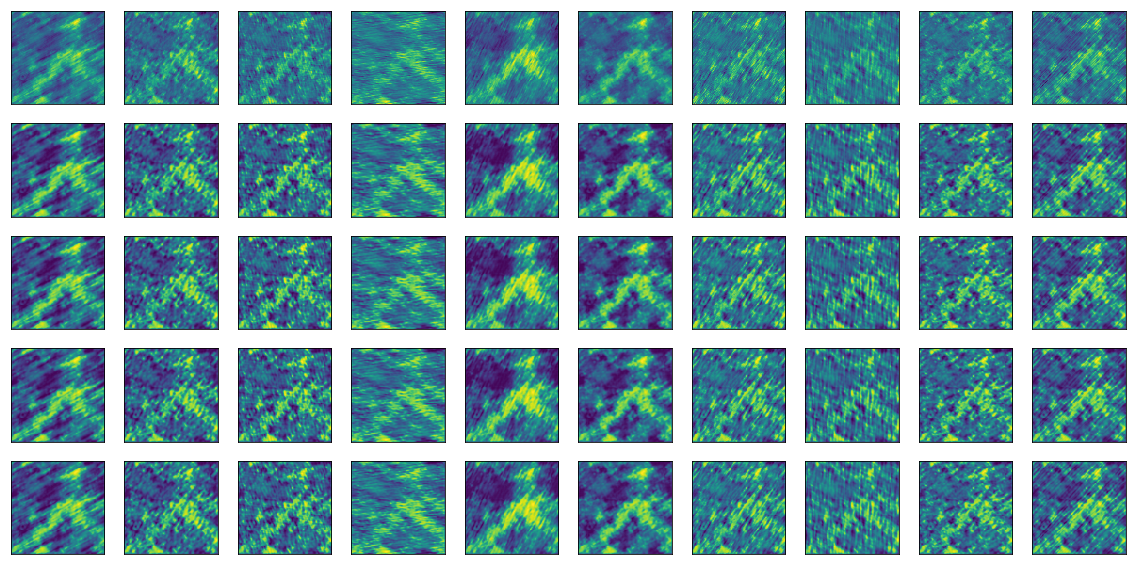

In [17]:
#rearranja a imagem do varmap experimental para uma dimensionalidade esperada pelo Keras:
#1ª dimensao: número de imagens (no caso soh uma)
#dimensões do meio: dimensões de cada imagem
#última dimensão: número de canais por imagem (no caso soh uma) para imagens muiltiespectrais ou RGB esse valor pode variar
#if( len(experimentalVarmap.shape) < 4 ) :
#    experimentalVarmap = experimentalVarmap.reshape((1,) + experimentalVarmap.shape + (1,))

#teste a predição com os variogramas de teste
decoded_imgs = autoencoder.predict( testSyntheticMaps )

nFigs = 10
plt.figure(figsize=(20, 10))
for i in range(nFigs):
    # display original
    ax = plt.subplot(5, nFigs, i+1)
    plt.imshow(testSyntheticMaps[i,:,:,0].reshape(getInputGridParameters().NI, getInputGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(5, nFigs, i + nFigs + 1)
    plt.imshow(decoded_imgs[i,:,:,0].reshape(getInputGridParameters().NI, getInputGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(5, nFigs, i + 2*nFigs + 1)
    plt.imshow(decoded_imgs[i,:,:,1].reshape(getInputGridParameters().NI, getInputGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(5, nFigs, i + 3*nFigs + 1)
    plt.imshow(decoded_imgs[i,:,:,1].reshape(getInputGridParameters().NI, getInputGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(5, nFigs, i + 4*nFigs + 1)
    plt.imshow(decoded_imgs[i,:,:,2].reshape(getInputGridParameters().NI, getInputGridParameters().NJ))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
